# PARAMETERS

In [1]:
n_qu = 4 # The number of qubits we will handle
#Pairs of CNOT gates
#pairs = [[0,1],[2,3],[2,4]]
pairs = [[0,1],[2,3]]

#
ns = [1,5]

# Import and show the MNIST dataset

In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

### Leave indexes of numbers to predict

In [3]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

indexesTr = [i for (i,x) in enumerate(train_y) if (x == ns[0] or x == ns[1])]
train_x = train_x[indexesTr]
train_y = train_y[indexesTr]
train_y = np.array([1 if x== ns[0] else -1 for (i,x) in enumerate(train_y)])

indexesTe = [i for (i,x) in enumerate(test_y) if (x == ns[0] or x == ns[1])]
test_x = test_x[indexesTe]
test_y = test_y[indexesTe]
test_y = np.array([1 if x== 3 else -1 for (i,x) in enumerate(test_y)])

#flatten
train_x_flat = train_x.reshape([train_x.shape[0],-1])
test_x_flat = test_x.reshape([test_x.shape[0],-1])

In [4]:
print(train_y)

[-1  1  1 ... -1  1 -1]


### Print images

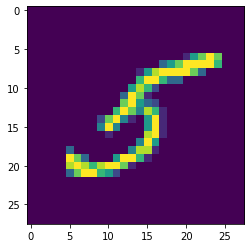

In [21]:
plt.imshow(train_x[8])

# PCA for preprocessing
### Imports

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Apply PCA and obtain the transformations

In [7]:
#normalizing data
scaler = StandardScaler()
scaler.fit(train_x_flat)
prep_data_train = scaler.transform(train_x_flat)

#Applying pca
pca = PCA(n_components = n_qu)
pca.fit(prep_data_train)
prep_data_train = pca.transform(prep_data_train)

### Preprocessing the testing data with the fitted models

In [8]:
prep_data_test = scaler.transform(test_x_flat)
prep_data_test = pca.transform(prep_data_test)

### lets reduce the amount of data upon which we'll train

In [9]:
index_sample = np.random.choice(list(range(prep_data_train.shape[0])), 200)
prep_data_train = prep_data_train[index_sample]
train_y = train_y[index_sample]

# Let's go Quantum!

### Imports

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.opflow import Z, I, StateFn, AerPauliExpectation
from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit import BasicAer
from qiskit_machine_learning.utils.loss_functions import L2Loss

### Create Quantum Circuit

c:\users\jjb_1\appdata\local\programs\python\python38\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


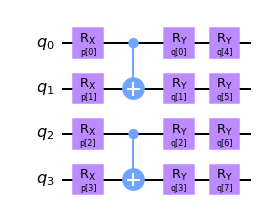

In [11]:
circuit = QuantumCircuit(n_qu)

params_data = ParameterVector('p', n_qu)
params_train = ParameterVector('q', n_qu*2)

for j in range(n_qu):
    #TODO: custome circuit, change gates
    circuit.rx(params_data[j], j)

for p in pairs:
    circuit.cx(p[0],p[1])

for j in range(n_qu*2):
    circuit.ry(params_train[j], j%n_qu)
circuit.draw()

In [12]:
sim = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(sim, shots=1024)

observable = Z ^ I ^ I ^ I

qnn_expectation = StateFn(observable, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation,
                input_params=params_data,
                weight_params=params_train,
                exp_val=AerPauliExpectation(),
                gradient=Gradient(),
                quantum_instance=quantum_instance)

opt = SPSA(maxiter=100)
classifier = NeuralNetworkClassifier(qnn, optimizer=opt, loss='l2')

<ipython-input-12-0287251f93b4>:16: DeprecationWarning: The loss argument value "l2" is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the "squared_error" value.
  classifier = NeuralNetworkClassifier(qnn, optimizer=opt, loss='l2')


### Training and testing

In [13]:
classifier.fit(prep_data_train, train_y)

In [14]:
classifier.score(prep_data_train, train_y)

0.515

In [15]:
classifier.score(prep_data_test, test_y)

0.4913665515540207